In [1]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from scipy import stats  # Add this import for the t-distribution

In [4]:
filepath = '../raw_data/total_factor_productivity.csv'

# Try reading with utf-8, fallback to latin1 if UnicodeDecodeError occurs
try:
	disp_df = pd.read_csv(filepath)
except UnicodeDecodeError:
	disp_df = pd.read_csv(filepath, encoding='latin1')

In [5]:
disp_df.head()

,naics4,year,sd,d7525,d9010,d9990,d1001,sd*,d7525*,d9010*,d9990*,d1001*
0,3111,1987.0,0.2883,0.2239,0.6477,0.6196,0.1455,0.2789,0.1947,0.4894,0.8043,0.1535
1,3111,1988.0,0.2782,0.1996,0.5330,0.8425,0.1384,0.3102,0.1529,0.5752,0.8945,0.1245
2,3111,1989.0,0.3253,0.1840,0.7220,0.7709,0.1533,0.3094,0.1547,0.5261,0.8397,0.1173
3,3111,1990.0,0.2954,0.2001,0.5154,1.037,0.1929,0.2927,0.1822,0.4714,0.7978,0.1004
4,3111,1991.0,0.2842,0.2235,0.5372,0.6796,0.2426,0.2842,0.1806,0.4711,0.7504,0.2352


In [10]:
disp_df.describe()

,year,sd,d7525,d9010,sd*,d7525*,d9010*
count,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000
mean,2003.500000,0.438629,0.500009,1.049623,0.361527,0.468077,0.874176
std,9.812386,0.149306,0.213762,0.389669,0.135884,0.274022,0.358649
min,1987.000000,0.158000,0.085440,0.348700,0.118400,0.063080,0.223600
25%,1995.000000,0.342675,0.372500,0.810275,0.285450,0.330700,0.671175
50%,2003.500000,0.409700,0.451950,0.968750,0.339850,0.415750,0.812300
75%,2012.000000,0.496425,0.566825,1.178000,0.406150,0.534175,1.003000
max,2020.000000,1.726000,2.125000,4.182000,1.574000,3.243000,3.756000


In [6]:
disp_df.columns

Index(['naics4', 'year', 'sd', 'd7525', 'd9010', 'd9990', 'd1001', 'sd*',
       'd7525*', 'd9010*', 'd9990*', 'd1001*'],
      dtype='object')

In [8]:
df = disp_df.copy()

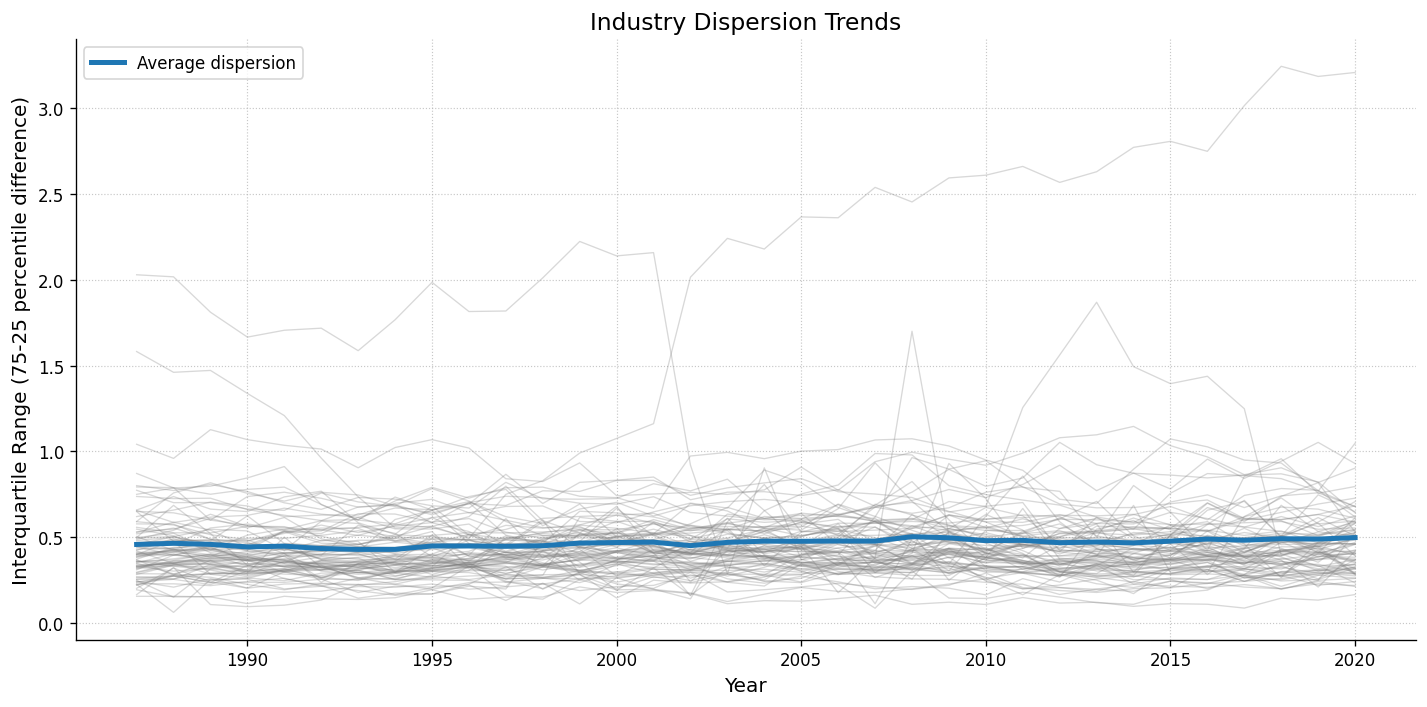

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure
plt.figure(figsize=(12, 6), dpi=120)
ax = plt.subplot(111)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)

# Plot individual industry trends in grey
industries = df['naics4'].unique()
for industry in industries:
    subset = df[df['naics4'] == industry]
    plt.plot(subset['year'], subset['d7525*'], 
             alpha=0.3, linewidth=0.8, color='grey')

# Add weighted average line (or simple average if no weights)
if 'weight' in df.columns:
    # Weighted average across industries
    weighted_avg = df.groupby('year').apply(
        lambda x: np.average(x['d7525*'], weights=x['weight'])
    )
    plt.plot(weighted_avg.index, weighted_avg.values, 
             linewidth=3, color='#1f77b4', label='Weighted average dispersion')
else:
    # Simple average if no weights
    average_by_year = df.groupby('year')['d7525*'].mean()
    plt.plot(average_by_year.index, average_by_year.values, 
             linewidth=3, color='#1f77b4', label='Average dispersion')

# Add labels and save
plt.xlabel('Year', fontsize=12)
plt.ylabel('Interquartile Range (75-25 percentile difference)', fontsize=12)
plt.title('Industry Dispersion Trends', fontsize=14)
plt.legend()
plt.tight_layout()


plt.savefig('/Users/danielseymour/Developer/EC334-Summative/figures/dispersion_trends.png', 
            dpi=300, bbox_inches='tight')
plt.show()

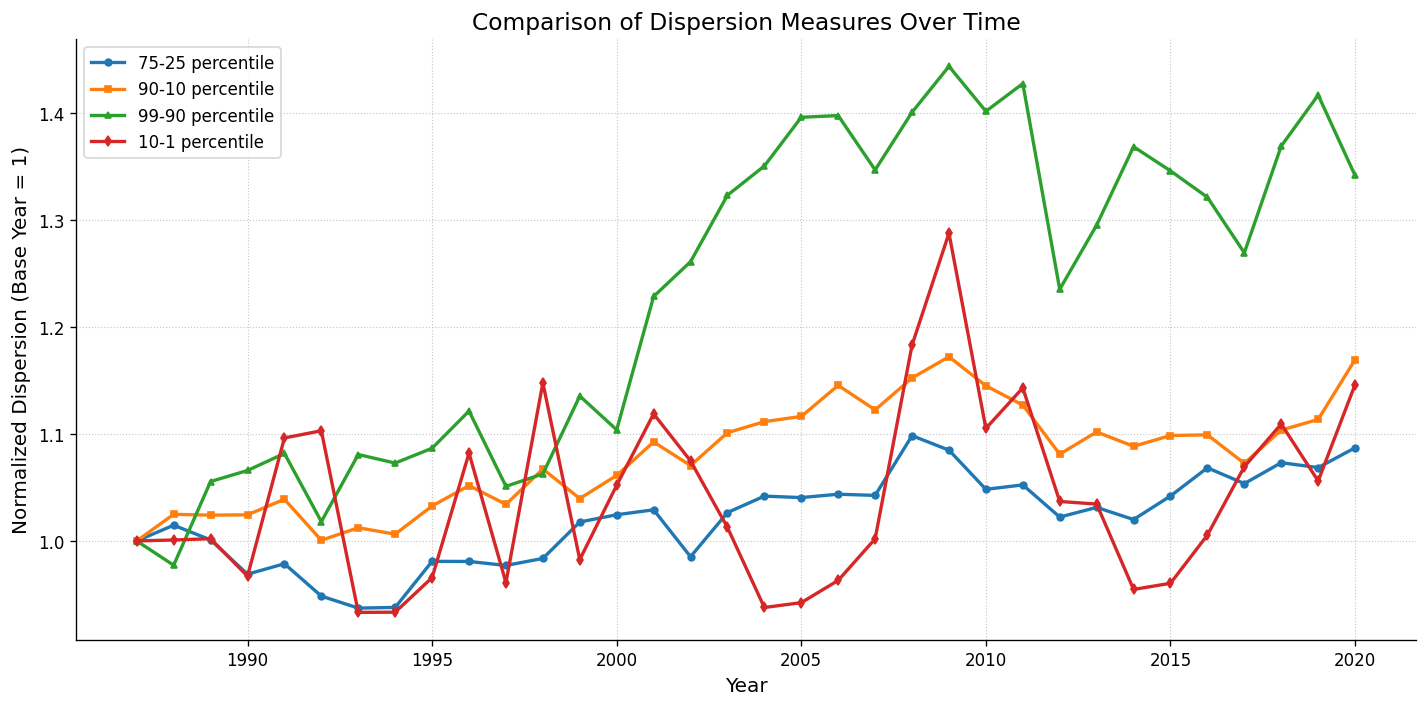

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure all dispersion columns are numeric, coerce errors to NaN
for col in ['d7525*', 'd9010*', 'd9990*', 'd1001*']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate average across industries for each dispersion measure
avg_dispersion = df.groupby('year')[['d7525*', 'd9010*', 'd9990*', 'd1001*']].mean()

# Normalize to make them comparable (optional)
normalized = avg_dispersion.div(avg_dispersion.iloc[0])  # Normalize to first year

# Set up the figure
plt.figure(figsize=(12, 6), dpi=120)
ax = plt.subplot(111)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)

# Plot each dispersion measure
plt.plot(normalized.index, normalized['d7525*'], 
         linewidth=2, marker='o', markersize=4, label='75-25 percentile')
plt.plot(normalized.index, normalized['d9010*'], 
         linewidth=2, marker='s', markersize=4, label='90-10 percentile')
plt.plot(normalized.index, normalized['d9990*'], 
         linewidth=2, marker='^', markersize=4, label='99-90 percentile')
plt.plot(normalized.index, normalized['d1001*'], 
         linewidth=2, marker='d', markersize=4, label='10-1 percentile')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized Dispersion (Base Year = 1)', fontsize=12)
plt.title('Comparison of Dispersion Measures Over Time', fontsize=14)
plt.legend()
plt.tight_layout()

# Save to the specified directory
plt.savefig('/Users/danielseymour/Developer/EC334-Summative/figures/dispersion_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

from this I am noticing that the difference between the 99th and 90th percentile productivity firms have increased but not much else

NameError: name 'df' is not defined

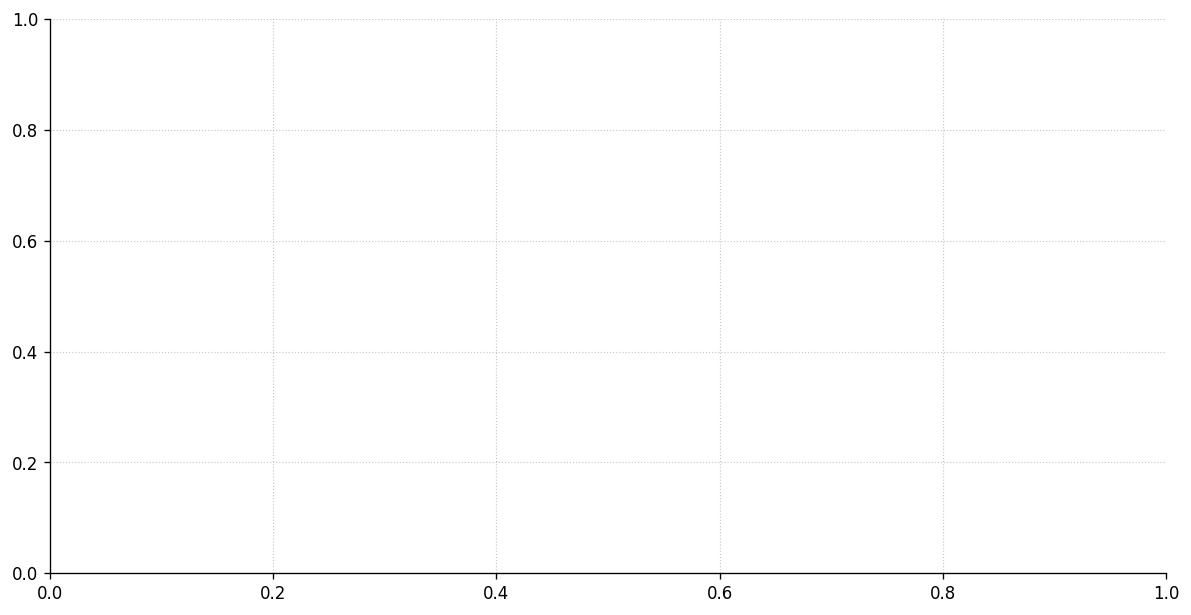

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming ci = boot_spread(productivity_long_df) has already been run
# and avg_dispersion contains your other dispersion measures

# Set up the figure
plt.figure(figsize=(12, 6), dpi=120)
ax = plt.subplot(111)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(which='major', linestyle=':', linewidth=0.7, alpha=0.7)
ax.set_axisbelow(True)

# Plot each original dispersion measure
avg_dispersion = df.groupby('year')[measures].mean()

for measure in measures:
    plt.plot(avg_dispersion.index, avg_dispersion[measure], 
             linewidth=2, marker='o', markersize=4, label=measure)

# Add the bootstrapped 99-90 spread with confidence interval
plt.plot(ci['Year'], ci['Spread'], 
         linewidth=2, marker='s', markersize=4, 
         color='purple', label='Bootstrapped 99-90 spread')

# Add shaded confidence interval
plt.fill_between(ci['Year'], ci['CI_low'], ci['CI_high'], 
                 color='purple', alpha=0.2)

# Labels and formatting
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dispersion Measure', fontsize=12)
plt.title('Comparison of Dispersion Measures Over Time', fontsize=14)
plt.legend()
plt.tight_layout()

# Save to specified directory
import os
os.makedirs('/Users/danielseymour/Developer/EC334-Summative/figures', exist_ok=True)
plt.savefig('/Users/danielseymour/Developer/EC334-Summative/figures/dispersion_with_bootstrap.png', 
            dpi=300, bbox_inches='tight')
plt.show()